# Experiment in dataviz: faces in a crowd

A few months ago I [trained models that could map a vector into a drawing of a face to create an esoteric data visualization](https://jessicastringham.net/2019/11/06/learning-chernoff-faces/) called [Chernoff faces](https://en.wikipedia.org/wiki/Chernoff_face).

Recently I packaged up some of the learned functions into my first every pypi package: [`vec2face`](https://pypi.org/project/vec2face/). Now you too can draw vectors as faces `vec2face` using `pip install vec2face`. 

To demonstrate the new package, I tried a new data visualization: faces in a crowd.


### Faces in a crowd for library catalog subject embeddings

I like how weird-but-maybe-useful Chernoff faces are, so tried to make it even more weird-but-maybe-useful by mapping out faces for a dataset. This creates a crowd of faces where one can pick out clusters and outliers.

To demo, I used the vector-representations of [library catalog subjects](https://jessicastringham.net/2018/05/16/library-catalog-subject/) from a previous post.

The vectors have sixteen values per library catalog subject. To choose the location of the face, I use UMAP to reduce the dataset to 2 dimensions. For the visualization, I create a grid and choose one data point to illustrate for each region. Then I used the `vec2face` class to illustrate these vectors.

In [1]:
# imports and helper functions you can skip over :D

import json
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import umap
import vec2face

SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

In [2]:
# hiding this code block in blog post

# Load vectors
with open('data/library_catalog_subject_vectors.json') as f:
    subject_vectors = json.load(f)
    subject_lookup = {
        item['subject']: i 
        for i, item in enumerate(subject_vectors)
    }
    subjects = [
        item['subject']
        for item in subject_vectors
    ]
    raw_catalog_vectors = np.array([
        item['vector']
        for item in subject_vectors
    ])

In [15]:
# hiding this code block in blog post

# initialize vec2face
v2f = vec2face.Vec2Face(dims=raw_catalog_vectors.shape[1])
v2f.learn_source_params(raw_catalog_vectors)  # normalize the vectors for me

# Learn some umap
reducer = umap.UMAP(min_dist=0.5)
raw_viz_emb = reducer.fit_transform(raw_catalog_vectors)

def plot_faces(max_dimension, annotate=False):
    
    # discretize umap
    norm_viz_emb = (raw_viz_emb - raw_viz_emb.min(axis=0))
    norm_viz_emb = norm_viz_emb/norm_viz_emb.max()
    viz_emb = norm_viz_emb * max_dimension
    viz_emb = viz_emb.astype(int)
    
    # plot faces
    fig, ax = plt.subplots(figsize=norm_viz_emb.max(axis=0) * max_dimension * (1.5 if annotate else 0.8))
    seen = set()
    for i, vals in enumerate(viz_emb):
        if tuple(vals) not in seen:
            # Draw the faces, and place them in the image
            v2f.draw_vec(
                raw_catalog_vectors[i], 
                ax, 
                scale=0.5 if annotate else 0.7,
                offset_x=vals[0],
                offset_y=vals[1],
            )
            if annotate:
                plt.annotate(
                    '\n'.join(textwrap.wrap(subjects[i][:40], 16)), 
                    xy=vals + np.array([0, 0.4]),
                    ha='center', va='center')
        seen.add(tuple(vals))
    plt.tight_layout()

## Map

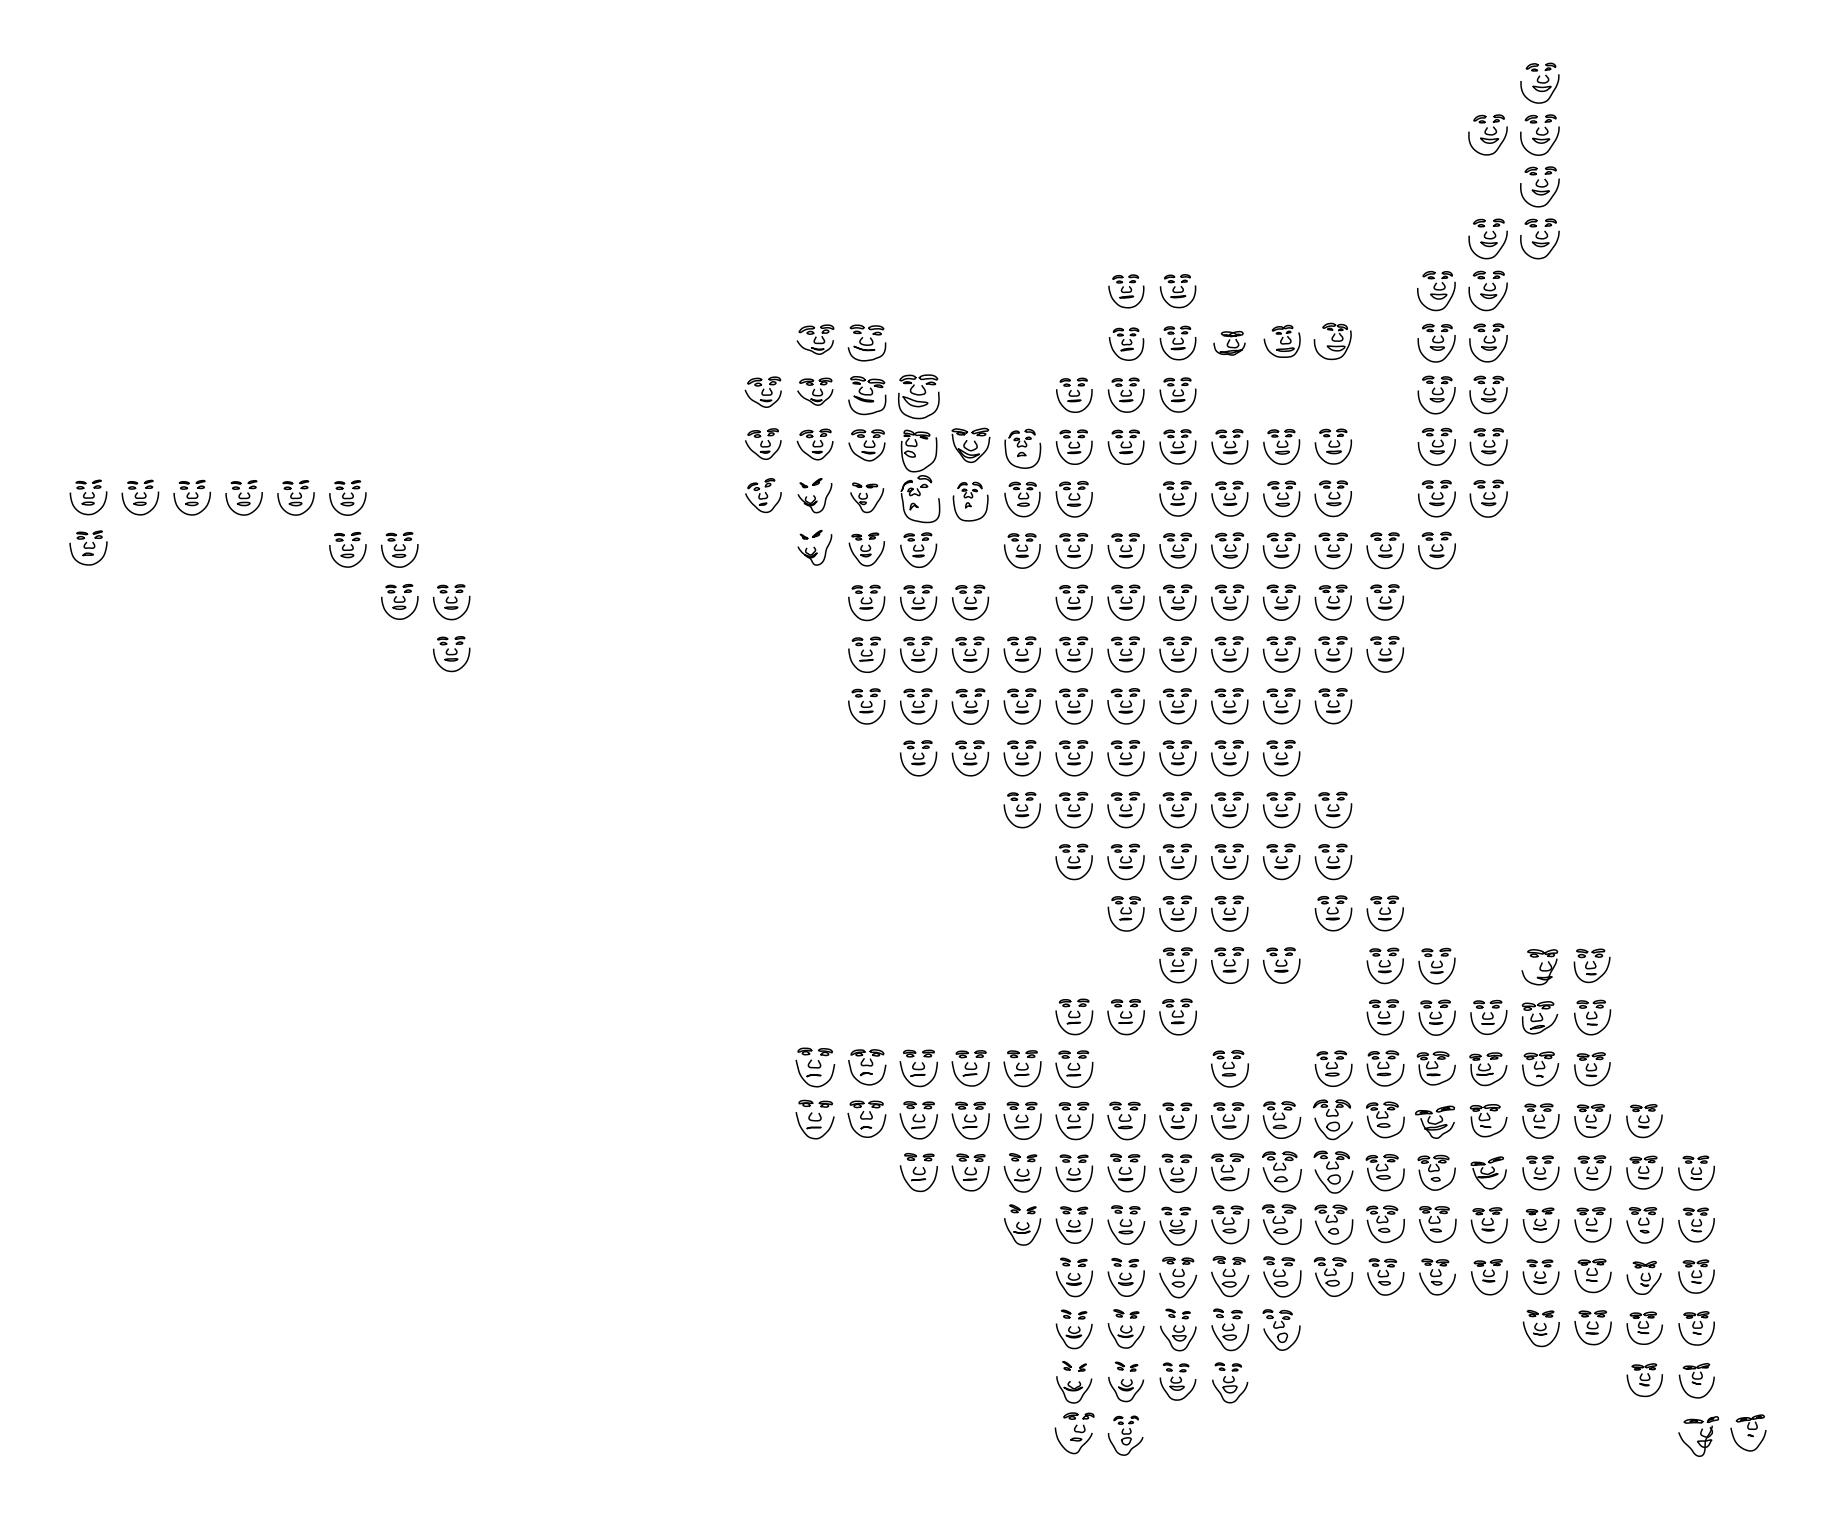

In [22]:
# hiding this code block in blog post

plot_faces(32, False)
maybe_save_plot('2020-01-06-facemap-many')

## Map with labels

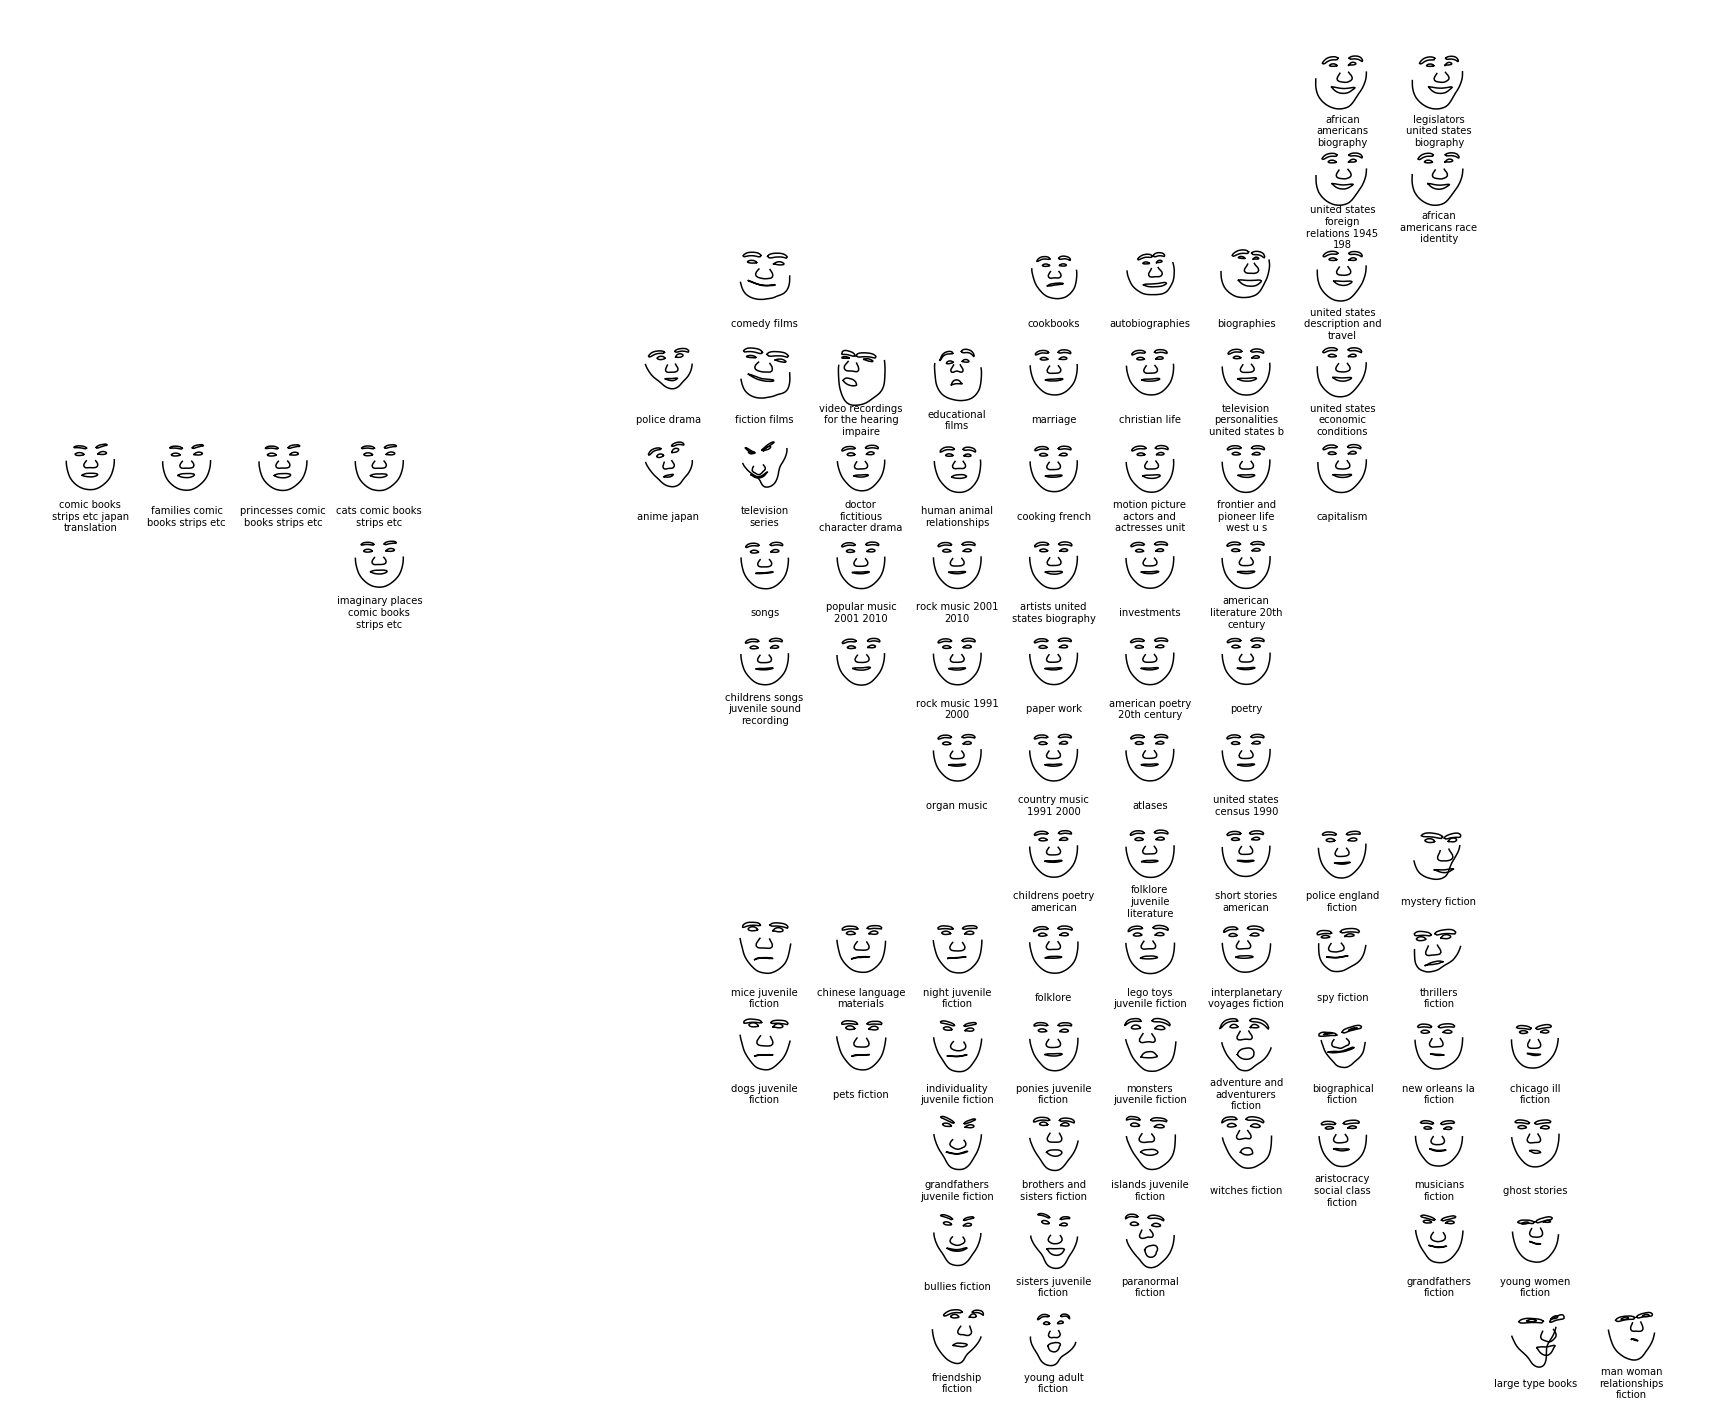

In [21]:
# hiding this code block in blog post

plot_faces(16, True)
maybe_save_plot('2020-01-06-facemap-labeled')

## What is it

I see this as an alternative visualization to the one I had in the original [embeddings](https://jessicastringham.net/2018/05/16/library-catalog-subject/). The original visualization used PCA instead of UMAP, shows all data points, and labels a few points.

<img src="https://jessicastringham.net/assets/2018-05-16-labeled-plot.png" width="300px">

When mapping the 16-dimensional data to two dimensions, some structure is lost. The faces are a way to represent the full 16-dimensional vector. For example, while data points might be neighbors in UMAP, they might have different enough vectors to make very different faces. Other times, the vectors might be different but it's harder to notice the difference between the faces.

<img src="images/2020-01-06-neighbors.png" width="300px">